In [1]:
import os, sys, sklearn, re
import BeautifulSoup as bs
import pandas as pd
import numpy as np

In [2]:
filepath_train = "/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM/TRAINING"

In [3]:
files = [{'file':f, 'path':os.path.join(filepath_train, f), 'content':'\n'.join(open(os.path.join(filepath_train, f)).readlines())} for f in os.listdir(filepath_train) if os.path.isfile(os.path.join(filepath_train, f))]

In [4]:
df_files = pd.DataFrame(files)
df_files.head()

,content,file,path
0,Return-Path: ler@lerami.lerctr.org\n\nDelivery...,TRAIN_00000.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...
1,From lkqyvstyles@site-personals.com Tue Aug 2...,TRAIN_00001.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...
2,X-Account-Key: account5\r\n\nX-UIDL: GmailId12...,TRAIN_00002.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...
3,From - Tue Oct 27 10:23:55 2009\r\n\nX-Account...,TRAIN_00003.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...
4,From www-data@mail.virtualed.org Tue Jul 30 2...,TRAIN_00004.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...


In [5]:
filepath_label = "/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM/SPAMTrain.label"
df_labels = pd.DataFrame.from_csv(filepath_label, sep=" ", header = None, index_col = None)
df_labels.columns = ['class','file']

In [6]:
df_labels.head()


,class,file
0,0,TRAIN_00000.eml
1,0,TRAIN_00001.eml
2,1,TRAIN_00002.eml
3,0,TRAIN_00003.eml
4,0,TRAIN_00004.eml


In [7]:
df_files_labeled = df_files.merge(df_labels)
df_files_labeled.head()

,content,file,path,class
0,Return-Path: ler@lerami.lerctr.org\n\nDelivery...,TRAIN_00000.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...,0
1,From lkqyvstyles@site-personals.com Tue Aug 2...,TRAIN_00001.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...,0
2,X-Account-Key: account5\r\n\nX-UIDL: GmailId12...,TRAIN_00002.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...,1
3,From - Tue Oct 27 10:23:55 2009\r\n\nX-Account...,TRAIN_00003.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...,0
4,From www-data@mail.virtualed.org Tue Jul 30 2...,TRAIN_00004.eml,/Users/Rolina/Desktop/SpamEmail/CSDMC2010_SPAM...,0


In [8]:
file_words = []

for idx, row in df_files_labeled.iterrows():
    word_counter = {}
    
#    print bs.BeautifulSoup(row['content'])
    content = row['content']
    parsed = re.sub(r'<[^<>]*>', '', content)
    words = [w.strip('(').strip(')').strip('"') for w in re.split(r'[!,\.\s\n]',parsed) if len(w)>0]
    for w in words:
        if w.lower() in word_counter:
            word_counter[w.lower()]+=1
        else:
            word_counter[w.lower()]=1
    file_words.append(word_counter)


In [9]:
df_words = pd.DataFrame(file_words).fillna(0)

In [10]:
df_filtered = df_words[df_words.columns[df_words.sum()>50]]

In [11]:
print df_words.shape
print df_filtered.shape

(4327, 183733)
(4327, 4017)


In [12]:
df_filtered.head()

,,#,#1,#2,#cc3366,$,$1,$100,$2,$25,...,zzzzteana@yahoogroups,{,{color:,|,},~/,�,�,,»
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Let's split the data into training and validation set

In [13]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(df_filtered.as_matrix(), df_files_labeled['class'], test_size=0.3, random_state=0)


###### Gaussian Naive Bayes model

In [14]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

###### Calculate the accuracy score

In [15]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.9761354888375674

###### Random forest model

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.9838337182448037

###### But why use one train/validation split? Let' do cross-validation

In [18]:
scores = sklearn.cross_validation.cross_val_score(clf, df_filtered.as_matrix(), df_files_labeled['class'])
scores.mean()

0.98312897342023542

##### Extra Trees Classifier

In [19]:
clf = sklearn.ensemble.ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=1, random_state=0)
scores = sklearn.cross_validation.cross_val_score(clf, df_filtered.as_matrix(), df_files_labeled['class'])
scores.mean()

0.98821322122293009

###### AdaBoost Classifier

In [20]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)
scores = sklearn.cross_validation.cross_val_score(clf, df_filtered.as_matrix(), df_files_labeled['class'])
scores.mean()

0.99098682593828225

###### Draw an ROC curve

In [21]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

In [22]:
y_score = [score[0] for score in clf.predict_proba(X_test)]

In [23]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score, pos_label = 0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(0.5, 1)

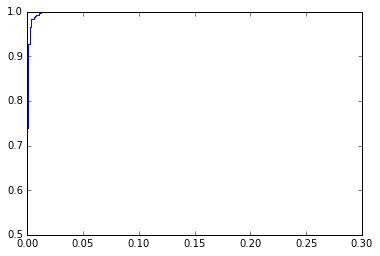

In [24]:
import matplotlib.pyplot as plt
%pylab inline
plt.plot(fpr, tpr)
plt.xlim(0,0.3)
plt.ylim(0.5,1)

In [25]:
pd.DataFrame({'fpr':fpr, 'tpr':tpr, '1-tpr':1-tpr, 'thresholds':thresholds}).sort(columns=['fpr', '1-tpr']).head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,1-tpr,fpr,thresholds,tpr
15,0.260664,0,0.550174,0.739336
14,0.537915,0,0.588560,0.462085
13,0.545024,0,0.588654,0.454976
12,0.715640,0,0.600912,0.284360
11,0.720379,0,0.601021,0.279621


In [26]:
pd.DataFrame({'fpr':fpr, 'tpr':tpr, '1-tpr':1-tpr, 'thresholds':thresholds}).sort(columns=['1-tpr', 'fpr']).head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,1-tpr,fpr,thresholds,tpr
33,0,0.012543,0.488512,1
34,0,0.045610,0.471480,1
35,0,0.047891,0.471390,1
36,0,0.062714,0.464232,1
37,0,0.064994,0.463709,1


###### How can we do better from here?

###### Now report the test error

In [27]:
filepath_train = "/Users/apple/Desktop/Kaggle/SpamEmail/CSDMC2010_SPAM/CSDMC2010_SPAM/TEST_extract"